In [38]:
library(jsonlite)
library(tidyverse)
library(tidyheatmaps)
# here library is not necessary as the data is big and in a different location

In [2]:
library(showtext)
font_add_google("Lato", "lato")
showtext_auto()

Loading required package: sysfonts

Loading required package: showtextdb



In [3]:
DATA_FOLDER <- "/mnt/f/big-data/vr_data/Data/preprocessing-pipeline/interpolated-colliders"
DATA <- Sys.glob(file.path(DATA_FOLDER, "*_interpolatedColliders_*.json"))

In [4]:
pids <- c(2002, 2005, 2008, 2009, 2015, 2016, 2017, 2018, 2024, 2006, 2007, 2013, 2014, 2021, 2020, 2025)
groups <- c("Control","Control","Control","Control","Control","Control","Control","Control","Control", "Glaucoma","Glaucoma","Glaucoma","Glaucoma","Glaucoma","Glaucoma", "Glaucoma")

In [5]:
get_buildings <- function(file_path = "../additional_Files/building_collider_list.csv") {
    building_csv_file <- file_path
    buildings <- read_csv(building_csv_file)
    buildings <- buildings %>% 
                    select(`...1`, target_collider_name, 
                            transformed_collidercenter_x, 
                            transformed_collidercenter_y) %>%
                    rename(
                        ID = `...1` ,
                        Name = target_collider_name,
                        x = transformed_collidercenter_x,
                        y = transformed_collidercenter_y
                    ) %>%
                    distinct(Name, .keep_all = TRUE)
    buildings
}

get_building_counter <- function() {
    buildings <- get_buildings()
    building_counter <- buildings %>% pull(Name) %>% reduce(function (acc, cur) {
            acc[[cur]] <- 0
            acc
        }, .init = list())
    # noData and newSession should be interpreted as buildings for the analysis before generating the graph
    building_counter[["noData"]] <- 0
    building_counter[["newSession"]] <- 0
    building_counter
}

In [11]:
get_cur_par_data <- function(data, building_counter, pid, group) {
    interpolated_data <- map(data, function(x) x$hitObjectColliderName) %>% unlist()
    durations <- map(data, function(x) x$clusterDuration) %>% unlist()

    # remove NH from the data
    nh_index <- interpolated_data == "NH"
    interpolated_data <- interpolated_data[!nh_index]
    durations <- durations[!nh_index]
    noisy <- durations < 250

    acc_data <- interpolated_data %>% reduce(
        function(acc, cur_building) {
            counter <- acc[[1]]
            data_table <- acc[[2]]
        
            counter[[cur_building]] <- counter[[cur_building]] + 1
            cur_row <- tibble(
                    building = cur_building,
                    view_count = counter[[cur_building]]
                )
            
            list(counter, bind_rows(data_table, cur_row))
        },
        .init = list(
                building_counter, 
                tibble(
                    building = character(),
                    view_count = numeric()
                )
        )
    )
    cur_data_tibble <- acc_data[[2]]

    cur_data_tibble <- cur_data_tibble %>% mutate(
        duration = durations,
        pid = pid,
        group = group,
        noisy = noisy
    )

    cur_data_tibble
}

In [25]:
building_data_tibble <- tibble(
    pid = integer(),
    group = character(),
    building = character(),
    duration = numeric(),
    view_count = numeric(),
    noisy = logical()
)

In [ ]:
for (data_file in DATA) {
    file_name <- basename(data_file)
    cur_p <- str_split(file_name, "_")[[1]][1] %>% as.integer()
    pid <- cur_p
    group <- groups[pids == pid]


    # json data processing
    cur_data <- read_json(data_file)
    building_counter <- get_building_counter()

    cur_data_tibble <- get_cur_par_data(cur_data, building_counter, pid, group)

    building_data_tibble <- bind_rows(building_data_tibble, cur_data_tibble)
}

In [27]:
building_data_tibble <- building_data_tibble %>% mutate(
    pid = factor(pid),
    group = factor(group),
    building = factor(building)
)    
    

In [30]:
nrow(building_data_tibble)

[1] 90733

In [65]:
library(repr)
# Change plot size to 8 x 3
options(repr.plot.width=45, repr.plot.height=25)

`summarise()` has grouped output by 'pid', 'group'. You can override using the `.groups` argument.


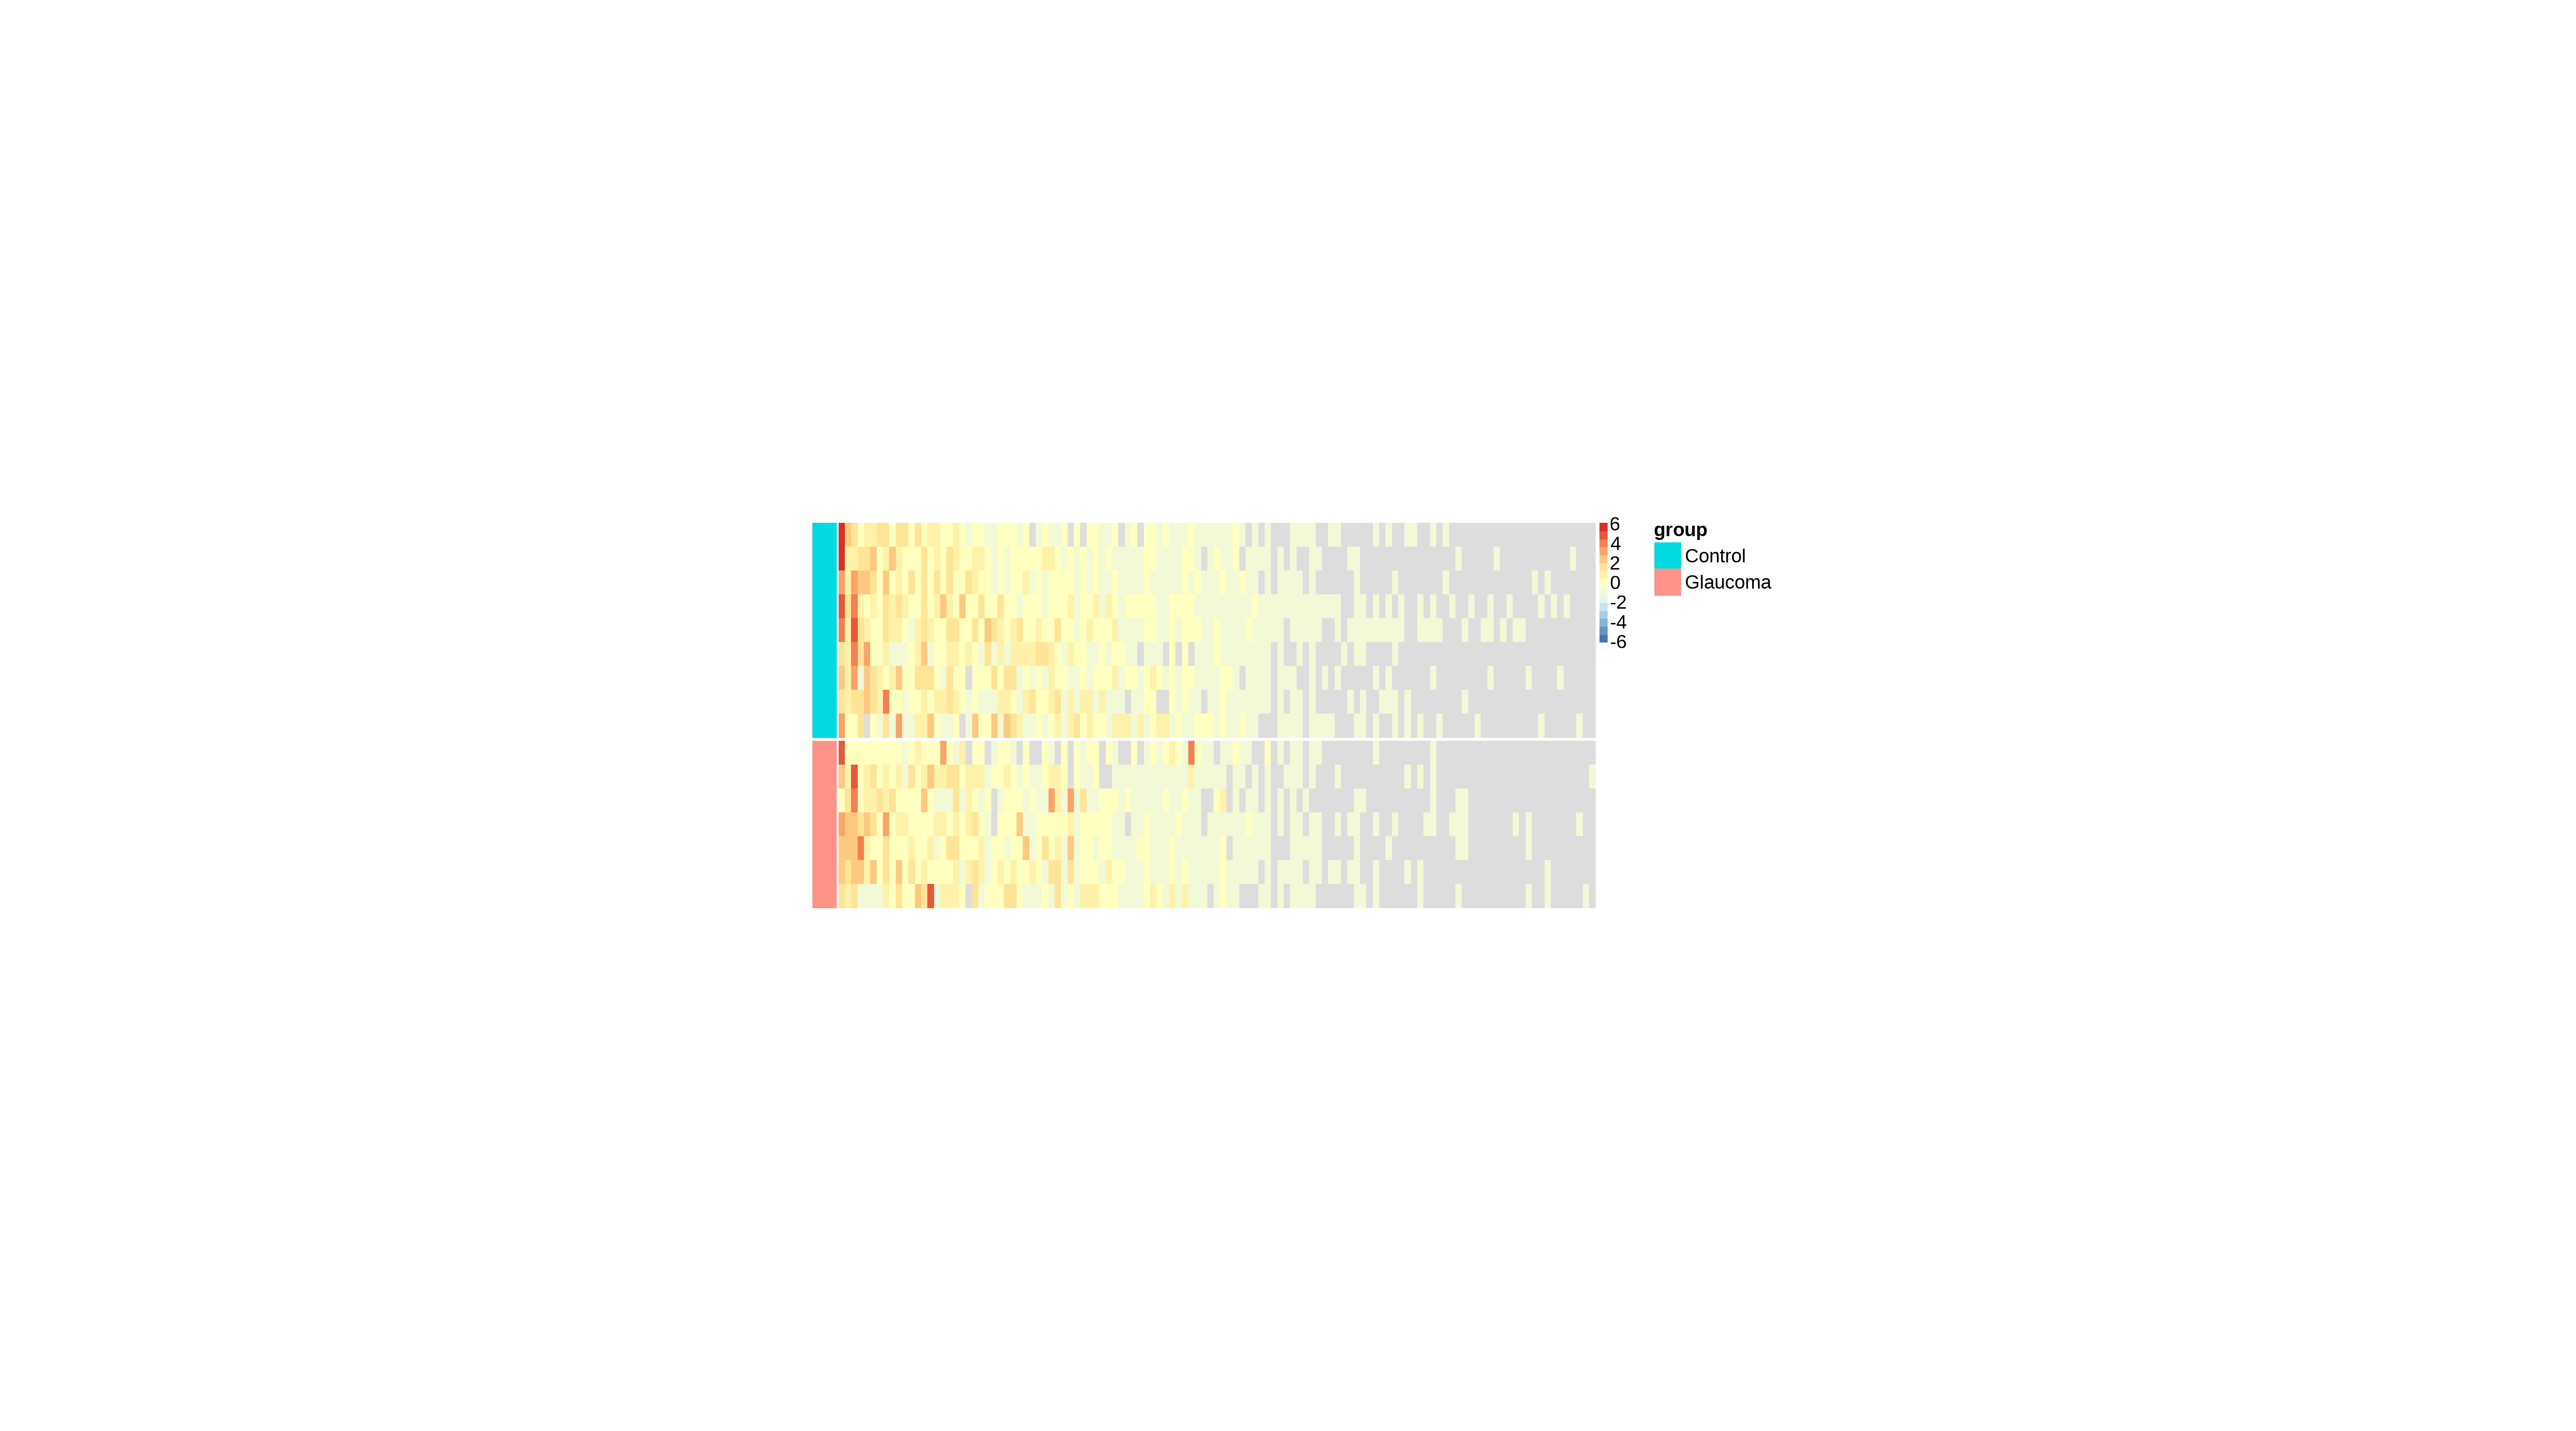

In [99]:
# duration sum for each building for each participant
building_data_tibble %>%
    filter(noisy == FALSE) %>% # noisy filter check
    select(pid, group, building, duration) %>%
    filter(building != "noData" & building != "newSession") %>%
    group_by(pid, group, building) %>%
    summarise(sum_duration = sum(duration) / 10000) %>%
    arrange(group, desc(sum_duration), building) %>%
    ungroup() %>%
    tidyheatmap(
        row = pid,
        column = building,
        values = sum_duration, 
        scale = "row",
        annotation_row = c(group),
        annotation_names_row = FALSE,
        gaps_row = group,
        cellwidth = 8,
        cellheight = 30,
        fontsize = 30,
        show_colnames = FALSE,
        show_rownames = FALSE
    )


`summarise()` has grouped output by 'pid', 'group'. You can override using the `.groups` argument.


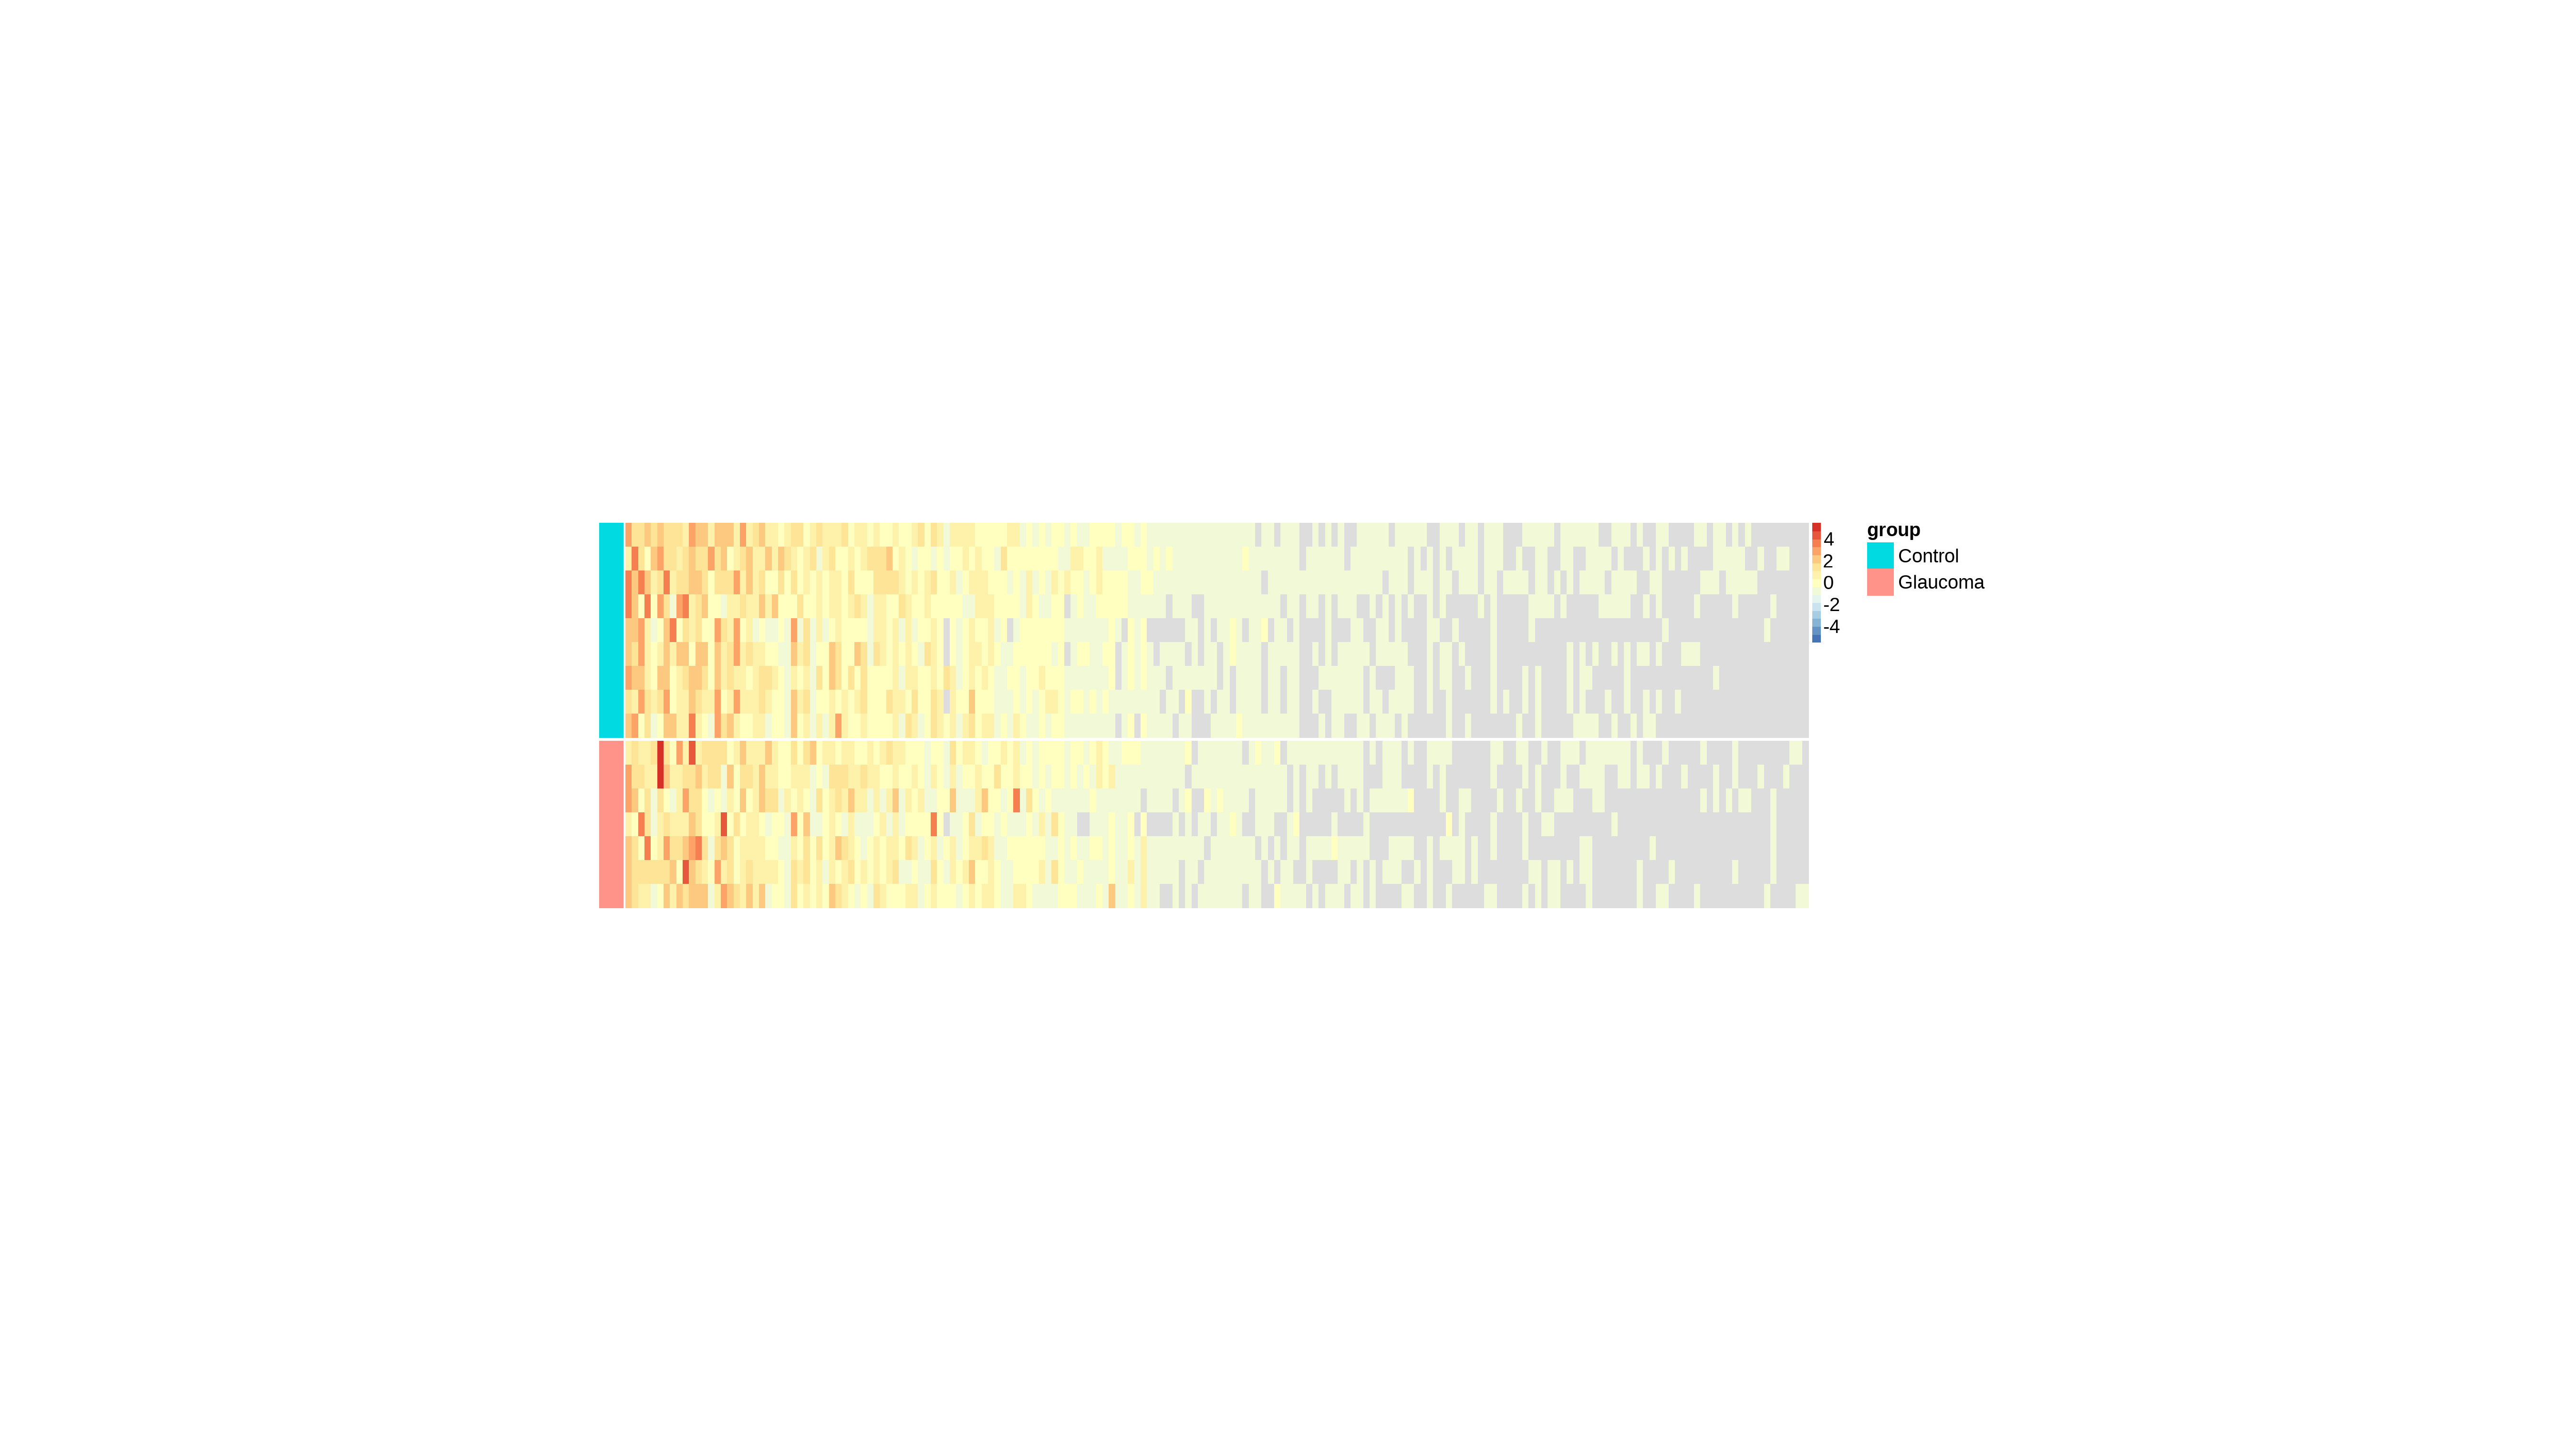

In [101]:
# view count for each building for each participant
building_data_tibble %>% 
    filter(noisy == TRUE) %>% # noisy filter check
    select(pid, group, building, duration, view_count) %>%
    filter(building != "noData" & building != "newSession") %>%
    group_by(pid, group, building) %>%
    summarise(
        sum_duration = sum(duration),
        mx_view_count = max(view_count)
    ) %>%
    arrange(group, desc(sum_duration), building) %>%
    ungroup() %>%
    tidyheatmap(
        row = pid,
        column = building,
        values = mx_view_count, 
        scale = "row",
        annotation_row = c(group),
        annotation_names_row = FALSE,
        gaps_row = group,
        cellwidth = 8,
        cellheight = 30,
        fontsize = 30,
        show_colnames = FALSE,
        show_rownames = FALSE
    )